In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["axes.grid"] = False
sc.settings.set_figure_params(dpi=80, dpi_save=180, vector_friendly=True, transparent=True) #for figures

In [2]:
#Read panNEC latest data:
results= "./pnec_anndata_082023/pNEC_updated_annot_07082023.h5ad"
adata= sc.read_h5ad(results)
adata.n_obs

45015

In [3]:
#Read Tosti's data: 
results_net = "/dh-projects/ag-ishaque/analysis/debnatho/pNET_scRNAseq_hilmar_2022/notebooks_analysis/Harmony_bbknn_pNET/AcinarI_subcluster_data_220822.h5ad"
adata_net= sc.read_h5ad(results_net)

adata_net.obs['Cluster_refined02']= adata_net.obs['cluster_label_intra_cluster']
adata_net.obs['Cluster_refined02']= adata_net.obs['Cluster_refined02'].astype('object')

#Subset Tosti's data only: 
adata_net= adata_net[adata_net.obs['sourceLabel']== 'Tosti']
#Convert to full dataset:
adata_tosti= adata_net.raw.to_adata()
print(adata_tosti.n_vars) 

18945


In [4]:
#Convert to a full object:
adata_pnet= adata.raw.to_adata()

print(adata_pnet.n_vars)
adata_pnet.X.expm1().sum(axis = 1)

32873


matrix([[ 9999.999],
        [10000.   ],
        [10000.002],
        ...,
        [10000.   ],
        [10000.001],
        [10000.002]], dtype=float32)

In [5]:
#Subset only the tumor cells:
adata_sub= adata_pnet[adata_pnet.obs['Cell types']!= "Immune"]
adata_sub.obs['Cell types'].cat.categories

Index(['Neuroendocrine', 'Amphicrine acinar', 'Stroma (normal)'], dtype='object')

Trying to set attribute `._uns` of view, copying.


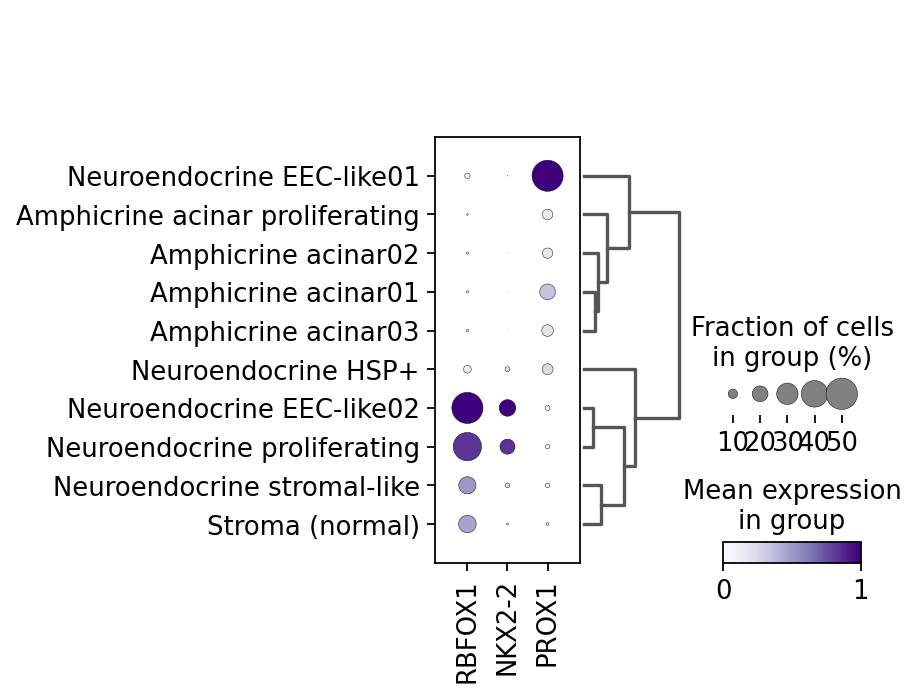

In [6]:
#RBFOX1 is Logistic Regression inferred robust marker for shared NE & NE proliferating
#RBFOX1 is responsible for brain like phenotype in shared NE cell states. 
sc.pl.dotplot(adata_sub, ['RBFOX1', 'NKX2-2', 'PROX1'], 
                         groupby= "Cell states", dendrogram=True, standard_scale="var", cmap= "Purples", dot_max=0.5) 

In [8]:
#Patient/sample-ID: 
adata_tosti.obs['PatientID']= adata_tosti.obs['patient_ID_new'] #make it consistent with pNET dataset. 
adata_tosti.obs['Cell types']= adata_tosti.obs['Cluster_refined02'] 
adata_tosti.obs['Cell states']= adata_tosti.obs['Cluster_refined02'] #to label as: Tosti, P7, P18, P19 & P24. 

adata_tosti.obs['Cell states'].value_counts()

Acinar-i         42968
Acinar-s         31570
Ductal           20371
Beta              4233
Acinar-REG+       3675
Alpha             1601
Delta             1018
MUC5B+ Ductal      225
Name: Cell states, dtype: int64

In [9]:
#Concatenate panNEC dataset with Tosti's adult pancreas:
adata_int= adata_tosti.concatenate(adata_sub, join= 'outer')
adata_int.n_obs

147731

In [10]:
adata_int.obs['Cell states']= adata_int.obs['Cell states'].astype('category')
print(adata_int.obs['Cell states'].cat.categories) 

Index(['Acinar-REG+', 'Acinar-i', 'Acinar-s', 'Alpha',
       'Amphicrine acinar proliferating', 'Amphicrine acinar01',
       'Amphicrine acinar02', 'Amphicrine acinar03', 'Beta', 'Delta', 'Ductal',
       'MUC5B+ Ductal', 'Neuroendocrine EEC-like01',
       'Neuroendocrine EEC-like02', 'Neuroendocrine HSP+',
       'Neuroendocrine proliferating', 'Neuroendocrine stromal-like',
       'Stroma (normal)'],
      dtype='object')


In [11]:
#Reorder the cell types/states before plotting: 
adata_int= adata_int[adata_int.obs['Cell states'].isin(['Acinar-REG+', 'Acinar-i', 'Acinar-s', 'Alpha',
       'Beta', 'Delta', 'Ductal', 'MUC5B+ Ductal', 'Neuroendocrine EEC-like01',
       'Neuroendocrine EEC-like02', 'Neuroendocrine HSP+',
       'Neuroendocrine proliferating', 'Neuroendocrine stromal-like'])]

adata_int.obs['Cell states'].value_counts()

Acinar-i                        42968
Acinar-s                        31570
Ductal                          20371
Neuroendocrine EEC-like02       10095
Neuroendocrine stromal-like      5668
Beta                             4233
Neuroendocrine proliferating     4033
Acinar-REG+                      3675
Neuroendocrine HSP+              2275
Alpha                            1601
Neuroendocrine EEC-like01        1488
Delta                            1018
MUC5B+ Ductal                     225
Name: Cell states, dtype: int64

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'orig_cell_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'DS' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cell' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'patient_ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'pancreas_location' as cat

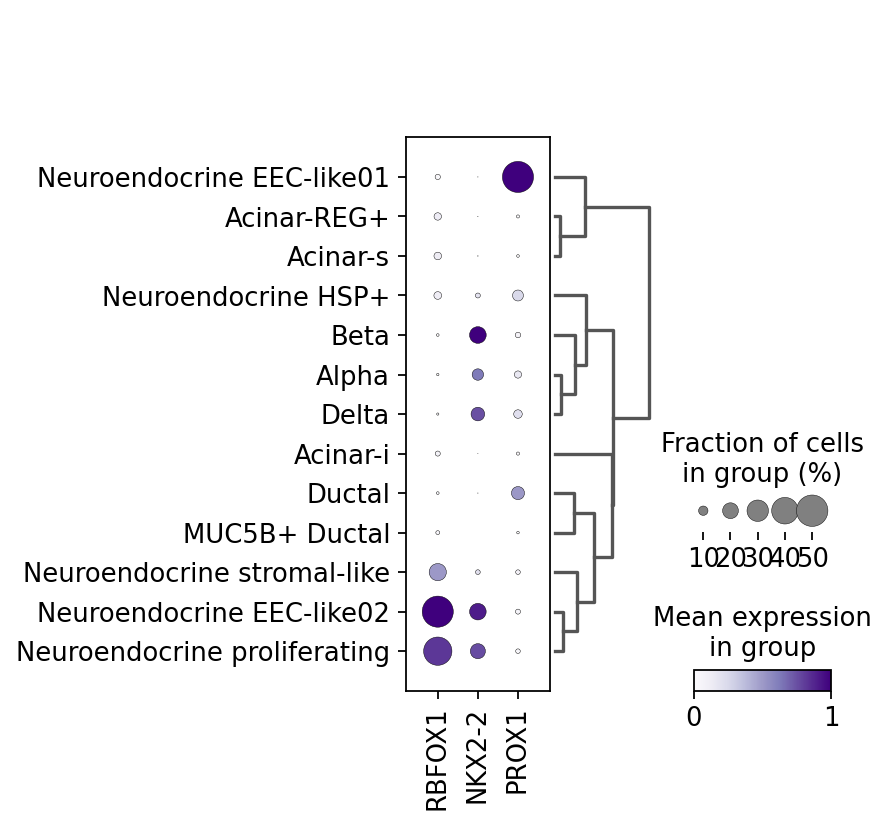

In [12]:
#RBFOX1: supports brain specific phenotype
#PROX1: Wnt signaling & supports amphicrine progenitor-like cell state explained in Suppl Info 
sc.pl.dotplot(adata_int, ['RBFOX1', 'NKX2-2', 'PROX1'], 
                         groupby= "Cell states", dendrogram=True, standard_scale="var", cmap= "Purples", dot_max=0.5, 
             save= "_ExtdFig3g_Tosti_RBFOX1_04042025.pdf") 

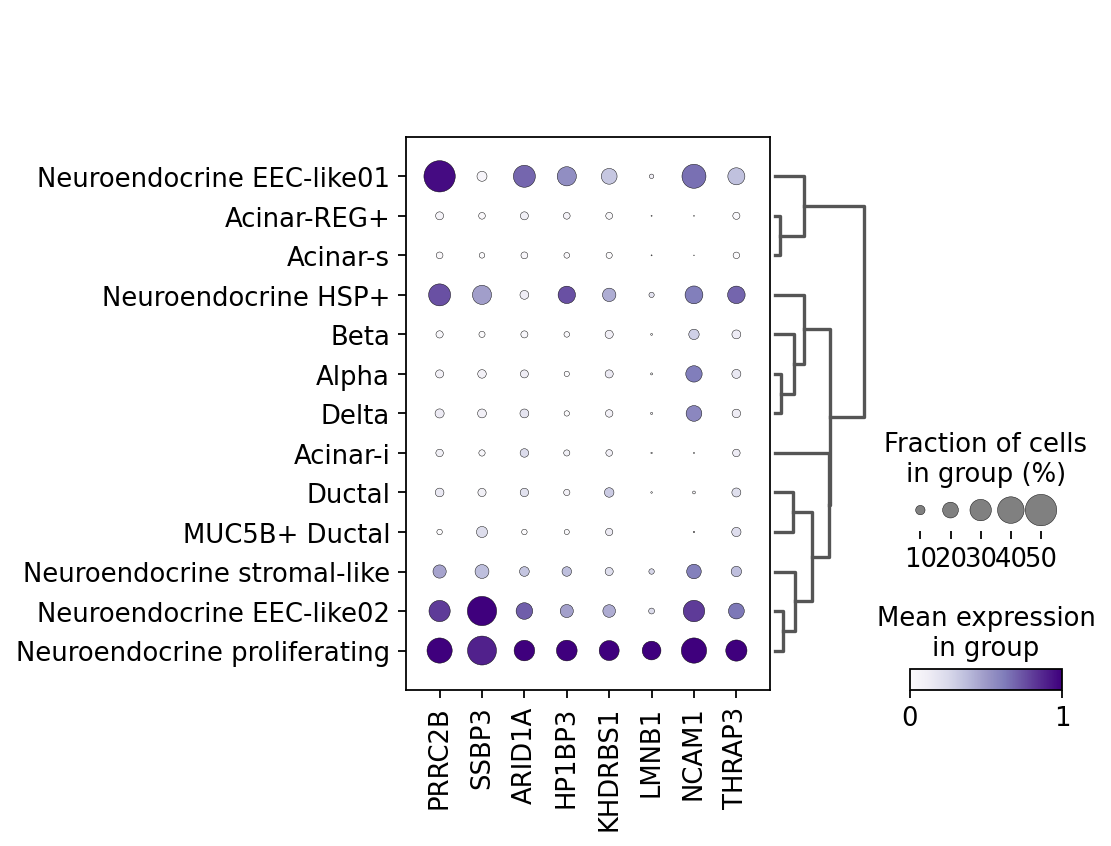

In [13]:
sc.tl.dendrogram(adata_int, groupby= "Cell states")

#Plot PTF1A/PAX6 targets for Tosti+panNEC integrated dataset
sc.pl.dotplot(adata_int, ['PRRC2B', 'SSBP3', 'ARID1A', 'HP1BP3', 'KHDRBS1', 'LMNB1', 'NCAM1', 'THRAP3'], 
                         groupby= "Cell states", dendrogram=True, standard_scale="var", cmap= "Purples", dot_max=0.5, 
             save= "_ExtdFig3h_Tosti_PTF1A_brain_targets_04042025.pdf") 